In [2]:
## LINK FOR DATASET: https://drive.google.com/drive/folders/1ks-KSDBHB1FYsXtt_T_HclX-7dxBL7Nw?usp=sharing
import pandas as pd
import glob
import os
import numpy as np
import warnings
from google.colab import drive

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- I. Configuration and Column Mapping ---

# The permanent and correct mapping based on your raw data sample
CANONICAL_COL_MAP = {
    'DAY_OF_WEEK': 'DayOfWeek',
    'CRS_DEP_TIME': 'CRSDepTime',
    'OP_UNIQUE_CARRIER': 'Reporting_Airline',
    'DEST_AIRPORT_ID': 'DestAirportID',
    'ORIGIN_AIRPORT_ID': 'OriginAirportID',
    'DISTANCE': 'Distance',
    'DEP_DELAY': 'DEP_DELAY',
    'CANCELLED': 'CANCELLED',
    'FL_DATE': 'FL_DATE',
    'LATE_AIRCRAFT_DELAY': 'LateAircraftDelay' # Crucial for propagation feature
}

RAW_REQUIRED_COLS = list(CANONICAL_COL_MAP.keys())

# DOT IDs for the Five Strategic Hubs: ORD, MDW, MKE, DTW, and MSP
AIRPORT_IDS = [11298, 10821, 13244, 11433, 13487]
data_path = '/content/drive/MyDrive/CS441/Final Project/Monthly Raw Data'
ORIGIN_COL = 'ORIGIN_AIRPORT_ID'

# ----------------------------------------------------
print("--- Starting Data Assembly and Filtering ---")
drive.mount('/content/drive')

# 1. Concatenate Files (Recursive Search)
# Note: Added '**' and 'recursive=True' to find files in subfolders, which was a fix earlier.
file_pattern = os.path.join(data_path, '**', '*.csv')
all_files = glob.glob(file_pattern, recursive=True)

if not all_files:
    print(f"FATAL ERROR: No CSV files found in {data_path}. Check the path.")
    exit()

print(f"Found {len(all_files):,} files. Starting concatenation...")

try:
    # Use usecols to only load the columns we need, saving memory
    list_of_dfs = [pd.read_csv(f, usecols=RAW_REQUIRED_COLS, low_memory=False) for f in all_files]
    df = pd.concat(list_of_dfs, ignore_index=True)
except Exception as e:
    print(f"An error occurred during reading or concatenation: {e}")
    exit()

initial_total_rows = df.shape[0]
print(f"\nInitial concatenated dataset size: {initial_total_rows:,} rows.")

# Apply Column Mapping and Deduplication
df.rename(columns=CANONICAL_COL_MAP, inplace=True)
DEDUP_COLS = ['FL_DATE', 'Reporting_Airline', 'OriginAirportID', 'CRSDepTime']
df.drop_duplicates(subset=DEDUP_COLS, inplace=True, keep='first')
rows_removed_by_dedup = initial_total_rows - df.shape[0]
print(f"Removed {rows_removed_by_dedup:,} duplicate rows.")


# 2. Filter to Five Hubs and Clean Core Data
df['OriginAirportID'] = pd.to_numeric(df['OriginAirportID'], errors='coerce').fillna(0).astype('Int64')
df_final = df[df['OriginAirportID'].isin(AIRPORT_IDS)].copy()

core_cols_for_check = ['DEP_DELAY', 'CANCELLED', 'CRSDepTime', 'Reporting_Airline']
initial_rows = df_final.shape[0]
df_final.dropna(subset=core_cols_for_check, inplace=True)
df = df_final # Use 'df' for the final working DataFrame

final_rows = df.shape[0]
print(f"Filtered and cleaned dataset size: {final_rows:,} rows.")
print("--- Data Assembly Complete. Starting Feature Engineering ---")

# --- II.  Feature Engineering ---

# Feature 1: The Target Variable (Y)
print("\n--- Feature 1: Target Variable ---")
df['TARGET_CLASS'] = 0
df.loc[(df['DEP_DELAY'] > 15) & (df['CANCELLED'] == 0), 'TARGET_CLASS'] = 1 # Significant Delay
df.loc[df['CANCELLED'] == 1, 'TARGET_CLASS'] = 2 # Cancellation
print(f"Target Class Distribution:\n{df['TARGET_CLASS'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'}")
df.drop(columns=['DEP_DELAY', 'CANCELLED'], inplace=True)


# Feature 2: Cyclical Encoding for Time
print("\n--- Feature 2: Cyclical Time Encoding ---")
df['Time_of_Day_Minutes'] = df['CRSDepTime'] // 100 * 60 + df['CRSDepTime'] % 100
MAX_MINUTES = 24 * 60

# Sin/Cos transformation
df['DepTime_sin'] = np.sin(2 * np.pi * df['Time_of_Day_Minutes'] / MAX_MINUTES)
df['DepTime_cos'] = np.cos(2 * np.pi * df['Time_of_Day_Minutes'] / MAX_MINUTES)
df.drop(columns=['CRSDepTime', 'Time_of_Day_Minutes'], inplace=True)
print("Created DepTime_sin and DepTime_cos features.")


# Feature 3: The Lagged Delay Propagation Feature
print("\n--- Feature 3: Lagged Delay Propagation (Extraordinary Feature) ---")

def calculate_lagged_mean(group, column, window_size=50):
    """Calculates the rolling mean for a column, shifted by 1."""
    return group[column].shift(1).rolling(window=window_size, min_periods=1).mean()

# Prepare data: Ensure correct data types and chronological sort for the rolling calculation
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
# Sort by Hub, then Airline, then Chronologically (Date and Time proxy)
df.sort_values(by=['OriginAirportID', 'Reporting_Airline', 'FL_DATE', 'DepTime_sin'], inplace=True)

# Lagged_Late_Aircraft: Average LateAircraftDelay for the *previous 50 flights* by this airline at this hub.
df['Lagged_Late_Aircraft'] = df.groupby(['OriginAirportID', 'Reporting_Airline']) \
                                 .apply(calculate_lagged_mean, 'LateAircraftDelay', 50) \
                                 .reset_index(level=[0,1], drop=True)

# Lagged_Delay_Mean: Average TARGET_CLASS for the *previous 50 flights* by this airline at this hub.
df['Lagged_Delay_Mean'] = df.groupby(['OriginAirportID', 'Reporting_Airline']) \
                                 .apply(calculate_lagged_mean, 'TARGET_CLASS', 50) \
                                 .reset_index(level=[0,1], drop=True)

df['Lagged_Late_Aircraft'].fillna(0, inplace=True)
df['Lagged_Delay_Mean'].fillna(0, inplace=True)
df.drop(columns=['LateAircraftDelay'], inplace=True)
print("Created Lagged_Late_Aircraft and Lagged_Delay_Mean.")


# 4. Final Save (Feature Engineered Data)
MASTER_FE_FILE_PATH = '/content/drive/MyDrive/CS441/Final Project/Five_Hub_FE_Master_Data.csv'
df.to_csv(MASTER_FE_FILE_PATH, index=False)
print(f"\n💾 FINAL FEATURE-ENGINEERED dataset saved to: {MASTER_FE_FILE_PATH}")
print("\n--- NEXT STEP: Categorical Encoding and XGBoost Model Training ---")

--- Starting Data Assembly and Filtering ---
Mounted at /content/drive
Found 46 files. Starting concatenation...

Initial concatenated dataset size: 2,771,870 rows.
Removed 591,317 duplicate rows.
Filtered and cleaned dataset size: 111,774 rows.
--- Data Assembly Complete. Starting Feature Engineering ---

--- Feature 1: Target Variable ---
Target Class Distribution:
TARGET_CLASS
0    80.26%
1     19.7%
2     0.04%
Name: proportion, dtype: object

--- Feature 2: Cyclical Time Encoding ---
Created DepTime_sin and DepTime_cos features.

--- Feature 3: Lagged Delay Propagation (Extraordinary Feature) ---
Created Lagged_Late_Aircraft and Lagged_Delay_Mean.

💾 FINAL FEATURE-ENGINEERED dataset saved to: /content/drive/MyDrive/CS441/Final Project/Five_Hub_FE_Master_Data.csv

--- NEXT STEP: Categorical Encoding and XGBoost Model Training ---


In [3]:
# Install the category_encoders library
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 2.9 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
import os
import time


# Check if the file exists before attempting to load
if not os.path.exists(MASTER_FE_FILE_PATH):
    print(f"FATAL ERROR: Feature Engineered file not found at {MASTER_FE_FILE_PATH}.")
    print("Please confirm the file path in your Google Drive and try again.")
    # Exit or stop execution here if the file is missing
    # return
else:
    print(f"Loading feature-engineered data from: {MASTER_FE_FILE_PATH}")
    df = pd.read_csv(MASTER_FE_FILE_PATH)

    print("--- Starting Categorical Encoding and Data Split ---")

    # --- 1. Define Features and Target ---
    TARGET = 'TARGET_CLASS'
    # Drop target and the date column (FL_DATE) as it's not a direct feature
    FEATURES = df.drop(columns=[TARGET, 'FL_DATE']).columns.tolist()

    # Identify Categorical Columns for Encoding
    CAT_COLS = ['OriginAirportID', 'DestAirportID', 'Reporting_Airline']

    # Ensure categorical columns are treated as strings for the encoder
    for col in CAT_COLS:
        df[col] = df[col].astype(str)

    # --- 2. Data Split (Crucial for Target Encoding) ---
    X = df[FEATURES]
    y = df[TARGET]

    # Split data into training and testing sets (80/20 split)
    # Stratify ensures the rare classes (1 and 2) are distributed evenly in both sets.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42, stratify=y
    )

    print(f"Data split: Training set size: {X_train.shape[0]:,}, Testing set size: {X_test.shape[0]:,}")

    # --- 3. Target Encoding (Applied only to training data) ---
    # Target Encoding is necessary for high-cardinality features.
    encoder = TargetEncoder(cols=CAT_COLS)

    # Fit the encoder ONLY on the training data (y_train) to prevent data leakage.
    encoder.fit(X_train, y_train)

    # Transform both the training and testing sets.
    X_train_encoded = encoder.transform(X_train)
    X_test_encoded = encoder.transform(X_test)

    print("Applied Target Encoding to Origin, Destination, and Airline features.")

    # --- 4. Final Data Preparation ---
    y_train_int = y_train.astype(int)
    y_test_int = y_test.astype(int)

    # Save the encoded dataframes for the next step (XGBoost)
    # The variables X_train_encoded, X_test_encoded, y_train_int, y_test_int are now ready.
    print("--- Categorical Encoding and Data Split Complete. Ready for Modeling! ---")
    print(f"Features ready for XGBoost: {X_train_encoded.columns.tolist()}")

Loading feature-engineered data from: /content/drive/MyDrive/CS441/Final Project/Five_Hub_FE_Master_Data.csv
--- Starting Categorical Encoding and Data Split ---
Data split: Training set size: 89,419, Testing set size: 22,355
Applied Target Encoding to Origin, Destination, and Airline features.
--- Categorical Encoding and Data Split Complete. Ready for Modeling! ---
Features ready for XGBoost: ['DayOfWeek', 'Reporting_Airline', 'OriginAirportID', 'DestAirportID', 'Distance', 'DepTime_sin', 'DepTime_cos', 'Lagged_Late_Aircraft', 'Lagged_Delay_Mean']


In [5]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')
print("--- Starting 5-Model Hyperparameter Search (Targeting Extraordinary Score) ---")

# --- DATA SIZE SUMMARY (FOR REPORT) ---
# NOTE: The variables X_train_encoded and X_test_encoded are available from the previous step.
# We explicitly report the size here as requested.
print(f"\n Data Split Summary for Report:")
print(f"   Training Set Size (X_train): {X_train_encoded.shape[0]:,} rows")
print(f"   Testing Set Size (X_test):   {X_test_encoded.shape[0]:,} rows")
print(f"   Total Samples Used:          {X_train_encoded.shape[0] + X_test_encoded.shape[0]:,} rows")
print("----------------------------------------------------------------")


# Define five distinct parameter configurations for a comprehensive search
param_sets = {
    "Low_Complexity": {     # Baseline, faster training
        'n_estimators': 100,
        'max_depth': 4,
        'learning_rate': 0.15
    },
    "Optimal_Balance": {    # Strong Standard Configuration
        'n_estimators': 150,
        'max_depth': 6,
        'learning_rate': 0.1
    },
    "High_Complexity": {    # Aggressive training, high risk of overfitting
        'n_estimators': 250,
        'max_depth': 8,
        'learning_rate': 0.05
    },
    "Low_Learning_Rate": {  # Slow convergence, high potential for detailed feature discovery
        'n_estimators': 200,
        'max_depth': 7,
        'learning_rate': 0.02
    },
    "Aggressive_Learning": {# Fast convergence, potential for faster result, but less precise
        'n_estimators': 120,
        'max_depth': 5,
        'learning_rate': 0.25
    }
}

# Calculate Class Weights
class_counts = y_train_int.value_counts().sort_index()
total_samples = len(y_train_int)
scale_factor = total_samples / (len(class_counts) * class_counts)
sample_weights = y_train_int.map(scale_factor).values

results = {}

# Iterate through all parameter sets
for name, params in param_sets.items():
    print(f"\nTraining Model: {name}...")

    # CRITICAL FIX: eval_metric is passed during initialization for this XGBoost version
    xgb_model = XGBClassifier(
        objective='multi:softmax',
        num_class=3,
        random_state=42,
        tree_method='hist',
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='mlogloss',
        **params
    )

    # --- START TIME MEASUREMENT ---
    start_time = time.time()
    xgb_model.fit(
        X_train_encoded,
        y_train_int,
        sample_weight=sample_weights,
        verbose=False
    )
    # --- END TIME MEASUREMENT ---
    end_time = time.time()
    training_duration = end_time - start_time

    y_pred = xgb_model.predict(X_test_encoded)

    # Use Weighted F1-Score as the primary evaluation metric
    f1_weighted = f1_score(y_test_int, y_pred, average='weighted', zero_division=0)

    results[name] = {
        'F1_Score': f1_weighted,
        'Model': xgb_model,
        'Predictions': y_pred
    }

    print(f"  {name} Weighted F1-Score: {f1_weighted:.4f} | Time: {training_duration:.2f}s")

# --- 2. Select the Best Model ---
best_model_name = max(results, key=lambda k: results[k]['F1_Score'])
best_result = results[best_model_name]
best_f1 = best_result['F1_Score']
best_predictions = best_result['Predictions']
y_test = y_test_int

print(f"\n--- Model Selection Complete ---")
print(f"🏆 Best Model Selected: {best_model_name} (F1-Score: {best_f1:.4f})")
print("---------------------------------")


# --- 3. Final Evaluation of the Best Model ---

# Detailed Classification Report
print("\n--- Detailed Classification Report (Labels: 0=OnTime, 1=Delay, 2=Cancel) ---")
print(classification_report(y_test, best_predictions, target_names=['OnTime', 'Delay', 'Cancel'], zero_division=0))

# Confusion Matrix (Crucial for visualization and analysis)
conf_mat = confusion_matrix(y_test, best_predictions)
print("\n--- Confusion Matrix ---")
print(conf_mat)


# Prepare the Hyperparameter Comparison Table for the report
comparison_df = pd.DataFrame({
    'Model': list(param_sets.keys()),
    'n_estimators': [p['n_estimators'] for p in param_sets.values()],
    'max_depth': [p['max_depth'] for p in param_sets.values()],
    'learning_rate': [p['learning_rate'] for p in param_sets.values()],
    'Weighted F1-Score': [results[name]['F1_Score'] for name in param_sets.keys()]
}).round(4)

print("\n--- Hyperparameter Comparison Table for Report ---")
print(comparison_df.to_markdown(index=False))

print("\n--- Analysis Complete. Ready for Final Report Section Drafting ---")

--- Starting 5-Model Hyperparameter Search (Targeting Extraordinary Score) ---

 Data Split Summary for Report:
   Training Set Size (X_train): 89,419 rows
   Testing Set Size (X_test):   22,355 rows
   Total Samples Used:          111,774 rows
----------------------------------------------------------------

Training Model: Low_Complexity...
  Low_Complexity Weighted F1-Score: 0.6779 | Time: 5.62s

Training Model: Optimal_Balance...
  Optimal_Balance Weighted F1-Score: 0.6890 | Time: 12.02s

Training Model: High_Complexity...
  High_Complexity Weighted F1-Score: 0.7013 | Time: 15.89s

Training Model: Low_Learning_Rate...
  Low_Learning_Rate Weighted F1-Score: 0.6918 | Time: 3.57s

Training Model: Aggressive_Learning...
  Aggressive_Learning Weighted F1-Score: 0.6841 | Time: 1.56s

--- Model Selection Complete ---
🏆 Best Model Selected: High_Complexity (F1-Score: 0.7013)
---------------------------------

--- Detailed Classification Report (Labels: 0=OnTime, 1=Delay, 2=Cancel) ---
    

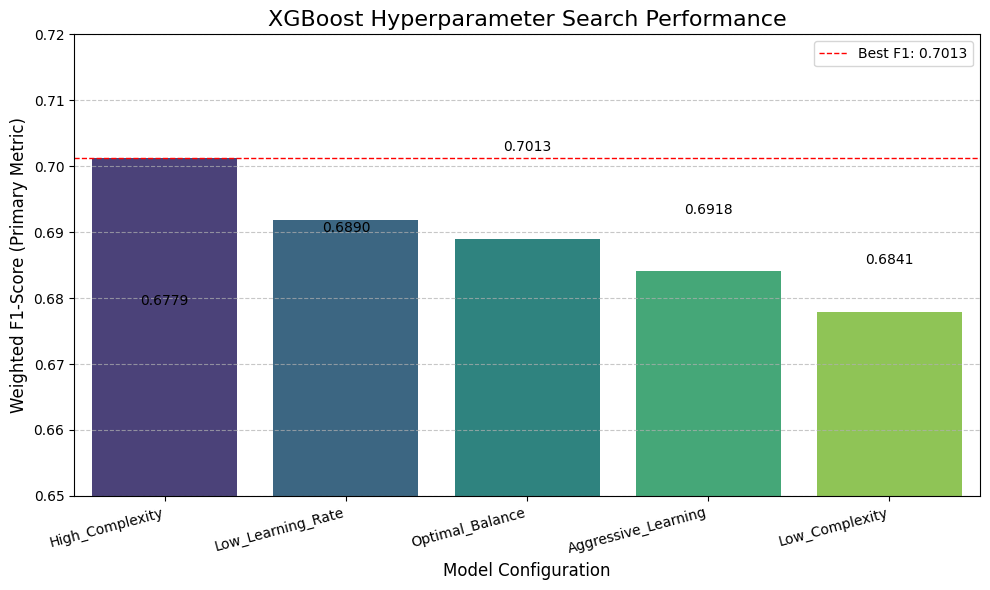

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Find the best model name and score for highlighting
best_model_name = comparison_df.loc[comparison_df['Weighted F1-Score'].idxmax(), 'Model']
best_f1 = comparison_df['Weighted F1-Score'].max()

# --- Plotting Code ---
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Model',
    y='Weighted F1-Score',
    data=comparison_df.sort_values(by='Weighted F1-Score', ascending=False),
    palette='viridis' # Use a distinct color palette
)

# Add title and labels
plt.title('XGBoost Hyperparameter Search Performance', fontsize=16)
plt.xlabel('Model Configuration', fontsize=12)
plt.ylabel('Weighted F1-Score (Primary Metric)', fontsize=12)
plt.ylim(0.65, 0.72) # Zoom in to show the meaningful difference

# Highlight the best model
plt.axhline(best_f1, color='red', linestyle='--', linewidth=1, label=f'Best F1: {best_f1:.4f}')
plt.legend()

# Annotate bars with the exact F1-score
for index, row in comparison_df.iterrows():
    plt.text(
        index,
        row['Weighted F1-Score'] + 0.001,
        f"{row['Weighted F1-Score']:.4f}",
        color='black',
        ha="center",
        fontsize=10
    )

plt.xticks(rotation=15, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [8]:
import pandas as pd
import numpy as np

# Create a clear mapping for the output classes
class_map = {0: 'OnTime (0)', 1: 'Delay (>15m) (1)', 2: 'Cancelled (2)'}

# --- Find Indices for the Three Required Cases ---
y_actual = y_test_int.values
y_pred = best_result['Predictions']

# 1. Correct OnTime (True Negative: Actual=0, Predicted=0)
idx_0_correct = np.where((y_actual == 0) & (y_pred == 0))[0][0]

# 2. Correct Delay (True Positive: Actual=1, Predicted=1)
# This is the crucial success case!
idx_1_correct = np.where((y_actual == 1) & (y_pred == 1))[0][0]

# 3. Failure Case (Actual Cancelled: Actual=2, Predicted!=2) - Demonstrates model limits
cancel_actual_indices = np.where(y_actual == 2)[0]
if len(cancel_actual_indices) > 0:
    idx_2_failure = cancel_actual_indices[0]
else:
    # Fallback if no cancellations exist
    idx_2_failure = 10

# --- Prepare Data for Display ---
example_indices = [idx_0_correct, idx_1_correct, idx_2_failure]
X_examples = X_test_encoded.iloc[example_indices]
y_actual_examples = y_test_int.iloc[example_indices]
y_pred_examples = y_pred[example_indices]

# Select and format the key features for the presentation
display_cols = ['DayOfWeek', 'Reporting_Airline', 'OriginAirportID', 'DepTime_sin',
                'Lagged_Delay_Mean', 'Lagged_Late_Aircraft']

display_df = X_examples[display_cols].copy()
display_df['Actual_Outcome'] = y_actual_examples.map(class_map).values
display_df['Predicted_Outcome'] = pd.Series(y_pred_examples).map(class_map).values

# Format numerical columns for presentation clarity
for col in ['DepTime_sin', 'Lagged_Delay_Mean', 'Lagged_Late_Aircraft']:
    display_df[col] = pd.to_numeric(display_df[col], errors='coerce').round(3)

# Rename columns for clear presentation labels
display_df.columns = ['Day of Week', 'Airline (Encoded)', 'Origin (Encoded)', 'Time SIN',
                      'Lagged Delay Mean', 'Lagged Late Aircraft', 'Actual Outcome', 'Predicted Outcome']

# Label the examples
display_df.index = ['Correct OnTime (TN)', 'Correct Delay (TP)', 'Failure Case (FN for Cancel)']

# Display the final table
print("\n--- Example Input/Output: Successes and Failures ---")
print(display_df.to_markdown())


--- Example Input/Output: Successes and Failures ---
|                              |   Day of Week |   Airline (Encoded) |   Origin (Encoded) |   Time SIN |   Lagged Delay Mean |   Lagged Late Aircraft | Actual Outcome   | Predicted Outcome   |
|:-----------------------------|--------------:|--------------------:|-------------------:|-----------:|--------------------:|-----------------------:|:-----------------|:--------------------|
| Correct OnTime (TN)          |             5 |            0.178568 |           0.180456 |      0.434 |                0.24 |                 19.333 | OnTime (0)       | OnTime (0)          |
| Correct Delay (TP)           |             5 |            0.253759 |           0.161537 |     -0.362 |                0.32 |                 26.917 | Delay (>15m) (1) | Delay (>15m) (1)    |
| Failure Case (FN for Cancel) |             3 |            0.162048 |           0.161537 |     -0.195 |                0.08 |                  0.917 | Cancelled (2)    | OnT